## Setup

If executing in Colab: Before we start, we will select a GPU. 'Entorno de ejecución', 'Cambiar tipo de entrono de ejecución', 'Acelerador de hardware', '[GPU](https://medium.com/datadriveninvestor/comparing-gpu-and-tpu-training-performance-on-google-colaboratory-c1e54e26993f)'.

### Necessary libraries and paths

In [0]:
from fastai.text import * 
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle as pkl

In [0]:
SAMPLE = True
PATH = Path('./sample') if SAMPLE else Path('.')
PATH.mkdir(exist_ok=True)

In [0]:
MODELS_PATH = PATH / 'models'
MODELS_PATH.mkdir(exist_ok=True)

### Connect with Google Drive to download necessary files

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive as storage
storage.mount('/content/gdrive')

### Download necessary files

In [0]:
!mkdir models

In [0]:
download = drive.CreateFile({'id': '1_0Kgr-2Hfywiaq4b-OE0YLblVnnv0QL_'})
download.GetContentFile(MODELS_PATH/'lm_enc.pth')

In [0]:
download = drive.CreateFile({'id': '1SSZ01bjf8_8xLboEBP2AFGTG5vslMpX2'})
download.GetContentFile(PATH/'vocab_lm.pkl')

## Preprocess training

In [0]:
import unicodedata
import pandas as pd

In [0]:
df = pd.read_csv('train_sp.csv')
df.head()

,title,label_quality,language,category
0,modulos cajas capsuladas tecla tecla,reliable,spanish,ELECTRONIC_SWITCHES
1,vefben llave palanca interruptor bipolar,reliable,spanish,ELECTRONIC_SWITCHES
2,interruptor conmutador bipolar embutir vefben ...,reliable,spanish,ELECTRONIC_SWITCHES
3,tecla pared wifi tc broadlink touch panel domo...,reliable,spanish,ELECTRONIC_SWITCHES
4,tecla interruptor dimmer tecnova linea clipsal,reliable,spanish,ELECTRONIC_SWITCHES


In [ ]:
#shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)
df.iloc[:200,:]
df.describe()

In [ ]:
df.groupby('category').count().describe()

In [0]:
#Save csv
df.to_csv(PATH / 'train_preproSP.csv', index=False)

## Classification

### Classification data

In [0]:
df_smp = pd.read_csv(PATH / 'train_preproSP.csv')

Now we create our 'databunch': an object that contains our datasets (train and validation) and our dataloaders. The dataloaders are iterables that we use to feed our model with batches of size 'batch_size'.

We must make sure that we use the same vocabulary (recongnized tokens) that we used in the language model. This will assure us that the model understands words and converts them to tokens in the same way.

In [0]:
with open(PATH/'vocab_lm.pkl', "rb") as input_file:
    lm_vocab = pkl.load(input_file)

In [0]:
if not (PATH / 'data_clas_exportSP.pkl').exists() or True:
    data_clas = TextClasDataBunch.from_csv(
        PATH, 
        'train_preproSP.csv', 
        vocab=lm_vocab, 
        bs=800, 
        text_cols='title', 
        label_cols='category'
    )
    
    data_clas.save('data_clas_exportSP.pkl')
else:
    data_clas = load_data(PATH, 'data_clas_exportSP.pkl')

In [0]:
data_clas.show_batch(rows=10)

text,target
xxbos cooler hp ac dx ac ca ac nr ac ds ac nr ac ds ac nr ac ds ac nr ac,DESKTOP_COMPUTER_COOLERS_AND_FANS
xxbos shadow of the tomb raider ps juego cd blu ray nuevo fisico sellado stock entrega inmediata,VIDEO_GAMES
xxbos morral macbook air pro tech medida different better by six hands crafts interes,NOTEBOOK_CASES
xxbos adaptador placa red wifi internet mbps conexion usb modelo dn antena dbi lanus,NETWORK_CARDS
xxbos tarjetas personales laminadas brillo troquelados especiales montados stamping sectorizados oro plata disen,IDENTIFICATION_AND_PRESENTATION_CARDS
xxbos manta frazada unicornio super suave abrigada arcoiris full time mania mercadolider platinum,BLANKETS
xxbos victorias secret llavero porta tarjetas sube metro card identificacion laboral equipaje packaging,LUGGAGE_TAGS
xxbos mesa cocina trampa extensible comedor rectangular diseno mirra abierta cano directo fabrica,DINING_TABLES
xxbos xiaomi xxunk ls cinta metrica digital medidor distancia laser telemetro retroiluminado profesional,LASER_MEASURES
xxbos torno electrico unas fresas manicuria pedicuria pies manos fresas profesional portable xxunk,MANICURE_AND_PEDICURE_DRILLS


In [0]:
data_clas.save('data_clas_smpSP.pkl')

In [0]:
data_clas = load_data(PATH,'data_clas_smpSP.pkl')

### Classifier training

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.13, bptt=12, path=PATH)
learn.load_encoder('lm_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 3.02E-02


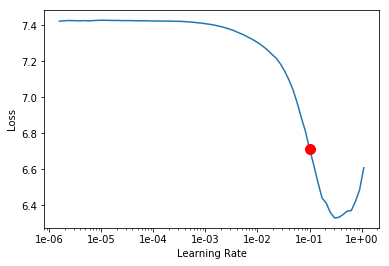

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=10, skip_start=15, suggestion=True)

In [0]:
learn.fit_one_cycle(1, 8e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.063942,0.899089,0.816057,08:56


In [0]:
learn.save('class_fit_headSP')

In [0]:
learn.freeze_to(-2)

In [0]:
learn.fit_one_cycle(1, slice(8e-3/(2.6), 8e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.806669,0.728497,0.847028,09:59


In [0]:
learn.save('class_fit_top2SP')

In [0]:
learn.load('class_fit_top2SP');

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(skip_end=20, skip_start=20, suggestion=True)

In [ ]:
learn.fit_one_cycle(
    3, slice(8e-4/(2.6), 8e-4), moms=(0.8, 0.7), 
    #callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='class_fit_full'), PrintingCallback()]
)

In [0]:
learn.save('class_fit_fullSP')

In [0]:
learn.load('class_fit_fullSP');

## Make submission

### Validation Balanced Accuracy

In [0]:
from sklearn.metrics import balanced_accuracy_score

probs = learn.get_preds(ds_type=DatasetType.Valid)
pred_indices = torch.argmax(probs[0], dim=1)
preds_clas = [data_clas.classes[pred] for pred in pred_indices]

In [0]:
true = [data_clas.classes[i] for i in probs[1].detach().numpy()]

Note: here we are calculating the balanced accuracy over both *reliable* and *unreliable* items, but the test set only contains *reliable* items.


In [0]:
balanced_accuracy_score(true, preds_clas)

0.8545726018106596

In [0]:
learn.predict('mercedes benz a ')

(Category CLASSIC_CARS,
 tensor(336),
 tensor([6.7881e-08, 9.8600e-08, 9.0583e-06,  ..., 1.0045e-05, 1.6540e-09,
         8.3562e-08]))

### Generate Submission

In [0]:
df = pd.read_csv('test_clean.csv')

In [0]:
df.pop('language');
df.pop('id');

In [0]:
df.head()

,title
0,maternidade bolsa mala baby bebe vinho menina kb
1,trocador fraldas fisher price feminino portatil
2,motor ventoinha fiat idea palio
3,amortecedor mola batente dir civic
4,cadeirinha carro bebe princesa princess kgs


In [0]:
learn.data.add_test(df, label=None)

In [0]:
learn.data.show_batch(ds_type=DatasetType.Test, rows=10)

text,target
xxbos maternidade bolsa mala baby bebe vinho menina kb,3D_GLASSES
xxbos trocador fraldas fisher price feminino portatil,3D_GLASSES
xxbos motor ventoinha fiat idea palio,3D_GLASSES
xxbos amortecedor mola batente dir civic,3D_GLASSES
xxbos cadeirinha carro bebe princesa princess kgs,3D_GLASSES
xxbos cabo freio mao direito vw up cod,3D_GLASSES
xxbos pc dell optiplex fx atom ram ssd wifi,3D_GLASSES
xxbos bi xenon lampada,3D_GLASSES
xxbos protetor pe botinha kickboxing karate taekwondo competicao,3D_GLASSES
xxbos disco rigido externo western digital elements tb usb,3D_GLASSES


In [0]:
probs = learn.get_preds(ds_type=DatasetType.Test)
pred_indices = torch.argmax(probs[0], dim=1)
preds_clas = [data_clas.classes[pred] for pred in pred_indices]

In [0]:
learn.data.test_ds[10], preds_clas[10]

((Text xxbos picadora carne fineschi legitima, EmptyLabel ), 'MEAT_GRINDERS')

In [0]:
learn.data.test_ds[100], preds_clas[100]

((Text xxbos gorras tycel claritos perforar puro latex, EmptyLabel ),
 'HAIRDRESSING_CAPS')

In [0]:
learn.data.test_ds[1000], preds_clas[1000]

((Text xxbos cepillo planchita alisador peine electrico, EmptyLabel ),
 'HAIR_STRAIGHTENING_BRUSHES')

In [0]:
df.head(5)

,id,title,language,category
0,0,maternidade bolsa mala baby bebe vinho menina kb,portuguese,DIAPER_BAGS
1,1,trocador fraldas fisher price feminino portatil,portuguese,BABY_CHANGING_PADS
2,2,motor ventoinha fiat idea palio,portuguese,ENGINE_COOLING_FAN_MOTORS
3,3,amortecedor mola batente dir civic,portuguese,SWAY_BARS
4,4,cadeirinha carro bebe princesa princess kgs,portuguese,BABY_CAR_SEATS


In [0]:
#save Spanish model submission
df.to_csv('submission_SP.csv', index=False)

In [0]:
!cp submission_SP19.csv gdrive/My\ Drive/